# Vanilla RNN, County-Level Daily Cases Data for Germany

Trying out the Vanilla RNN model on the county-level data for Germany

## Task and RNN Model

**Data**: Time-series for Germany from European Regional Tracker Dataset
- Time series $\mathbf{y}_i = [\mathbf{y}_i(1), \mathbf{y}_i(2), ..., \mathbf{y}_i(T)]^t$
- $\mathbf{y}_i(t) \in \mathbb{R}$ denotes  (normalized) number of new cases on $t$-th recorded day for region $i$

**Model**: Non-Autonomous Vanilla RNN (also tried gated recurrent unit, equations not shown here)
- Equations: 
$$
\mathbf{h}(t+1) = \tanh \big( \mathbf{W}_{hh} \mathbf{h}(t) + \mathbf{W}_{yh} \textrm{SW}[y_i,\tau_-](t) + \mathbf{b}_h\big)
$$

$$
\textrm{SW}[y,\tau](t) = [y(t-1),y(t-2),...,y(t-\tau)]^t
$$

$$
\mathbf{y}_{pred}(t) = \tanh\big(\mathbf{W}_{hy} \mathbf{h}(t) + b_y \big)
$$

- Trainable parameters:
    - Input-hidden weights $\mathbf{W}_{yh}$, a $N_h \times \tau$ matrix
    - Hidden-hidden weights $\mathbf{W}_{hh}$, a $N_h \times N_h$ matrix
    - Hidden-output weights $\mathbf{W}_{hy}$, a $1 \times N_h$ matrix
    - Hidden bias vector $\mathbf{b}_{h}$, a $N_h$-D Vector
    - Output bias vector $b_{y}$, a scalar
    - Initial Hidden State $\mathbf{h}(0)$, a $N_h$-D Vector
    
**Optimization Goal**: Train RNN such that $\mathbf{y}_{pred}(t)$ close to $\mathbf{y}(t+\tau_+)$

More specifically, we want to find $\mathbf{\Theta} = (\mathbf{W}_{hh}, \mathbf{W}_{yh}, \mathbf{W}_{hy}, \mathbf{b}_{h}, b_y, \mathbf{h}(0))$ that minimizes

$$
\textrm{RMSE}(\mathbf{y}_i, \mathbf{y}_{pred}) = \bigg[\frac{1}{T} \sum_{t=1}^{T-\tau_+} |\mathbf{y}_i(t+\tau_+) - \mathbf{y}_{pred}(t)|^2\bigg]^{1/2} 
$$

averaged over all regions $i=1,...,R$.


In [1]:
# Change root directory
import sys, os
sys.path.append(os.path.abspath('../../'))

In [2]:
# Package Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA

# MLP text size
import matplotlib
matplotlib.rc('font', size=16)

In [3]:
# Local Imports
from src.baseline_models import RNN
from src.baseline_gated_models import GRU
from src.load_data import ERT_germany
from src.train_and_eval import train
from src.clustering import hierarchical_clustering

## Parameters

In [59]:
# Dataset parameters
dtype = 'cases_daily'
T = 100
tau_minus = 7 # Sliding window size for inputs
tau_plus  = 3 # Slide window for outputs. Currently un-used
country_wide_total = False
per_10k_population = False
normalize = False
squash_to = (0,1)
smooth = 7
p_tr = 0.8    # Portion (0-1) of the dataset used for training

# Model parameters
N_h = 64
p_hh = 1
g_hh = 1
f_h = 'tanh'
f_out = 'tanh'
sigma = 0e-3 # noise parameter
tau = 2
learn_tau = False

# Training parameters
n_epochs = 20
batch_size = 16
lr = 3e-3
lr_decay = 1
weight_decay = 0.0
batches_til_first_lr_update=256
clip_gradient_thres=None
verbose = True

## Setup

In [60]:
# Function to compute a sliding windows of the input time-series
def compute_SW(y, tau):
    """
    Given a tensor y of shape (N,T), returns a new tensor SW
    of show (N,T,tau) where
    
                SW[i,t,k] =   0          if t-k < 0
                              y[i,t-k]   else
    
    where k = 0, 1, ..., tau-1
    """
    N,T = y.shape
    SW = -torch.ones((N,T,tau))
    for k in range(tau):
        SW[:,k:,k] = y[:,:(T-k)]
    return SW

In [61]:
# Random Seed
seed = np.random.randint(1e6)
print('Random seed: %d' % seed)
np.random.seed(seed)

# Load the dataset
# directory where the data is stored, relative to this script
datadir = '../../euro_regional_tracker/germany_data/data'
# load the data from file
y_all = ERT_germany(dtype=dtype, seq_len=T, 
    smooth=smooth, squash_to=squash_to,
    per_10k_population=per_10k_population,
    country_wide_total=country_wide_total,
    normalize=normalize, datadir=datadir
)

# Create the target output sequences
#  (Same as y_all, but starting at day tau_plus
#   so the network learns to make predictions for
#   the future)
y = y_all.view(-1,T,1)[:,tau_plus:].contiguous()

# Create the input sequence
# Note: We need to truncate the sequence to length 
#   T-tau_plus to match the length of the target output
#   sequences
u = compute_SW(y_all, tau_minus)[:,:(T-tau_plus)]

# Create the RNN model
# network = RNN(
#     tau_minus, N_h, 1,
#     f_h=f_h, f_out=f_out, g_hh=g_hh, p_hh=p_hh,
#     tau=tau, learn_tau=learn_tau
# )
network = GRU(
    tau_minus, N_h, 1, f_out=f_out
)

Random seed: 203710


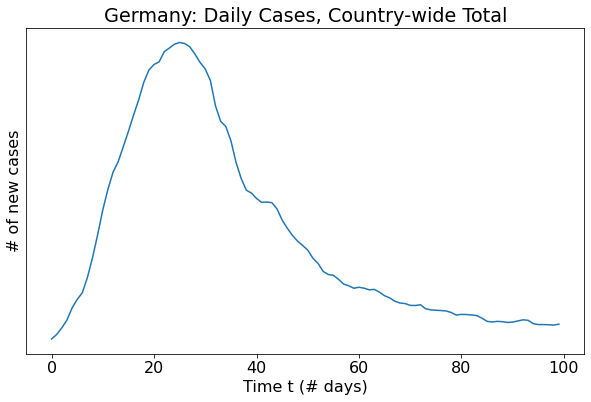

In [62]:
# Plot of what the raw data looks like
y_country = y_all.sum(axis=0)
y_country -= y_country.min()
plt.figure(figsize=(10,6))
plt.title('Germany: Daily Cases, Country-wide Total')
plt.xlabel('Time t (# days)')
plt.ylabel('# of new cases')
plt.yticks([])
plt.plot(y_country)
plt.show()

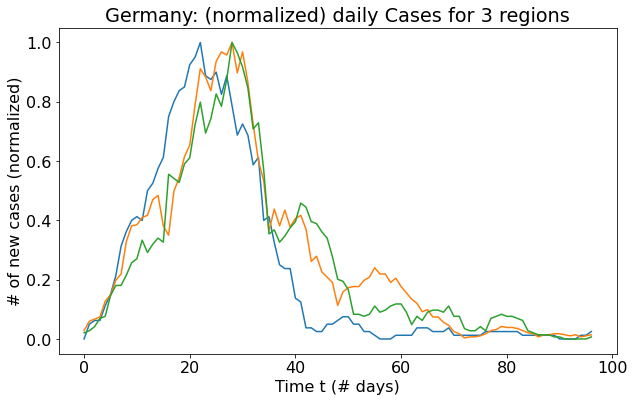

In [63]:
# Example plots of different regions
n_regions = 3
region_ids = np.random.choice(np.arange(y.shape[0]), replace=False, size=n_regions)
plt.figure(figsize=(10,6))
plt.title('Germany: (normalized) daily Cases for %d regions' % n_regions)
plt.xlabel('Time t (# days)')
plt.ylabel('# of new cases (normalized)')
for i in region_ids:
    plt.plot(y[i])
plt.show()

## Training

In [64]:
# Split into a train and test sets
n_train = int(p_tr * y.shape[0])
random_perm = torch.randperm(u.shape[0])
u_train, u_test = u[random_perm[:n_train]], u[random_perm[n_train:]]
y_train, y_test = y[random_perm[:n_train]], y[random_perm[n_train:]]

print('Train set: %d examples' % n_train)
print('Test  set: %d examples' % (u.shape[0]-n_train))

Train set: 320 examples
Test  set: 81 examples


In [65]:
losses, = train(network, u_train, y_train, n_epochs, batch_size, lr, 
        lr_decay=lr_decay, weight_decay=weight_decay,
        batches_til_first_lr_update=batches_til_first_lr_update,
        clip_gradient_thres=clip_gradient_thres, verbose=True,
        test_set=(u_test,y_test)
)

  Epoch 1/20, Eval 1/20, Loss: 0.059
  Epoch 1/20, Eval 2/20, Loss: 0.040
  Epoch 1/20, Eval 3/20, Loss: 0.034
  Epoch 1/20, Eval 4/20, Loss: 0.033
  Epoch 1/20, Eval 5/20, Loss: 0.034
  Epoch 1/20, Eval 6/20, Loss: 0.032
  Epoch 1/20, Eval 7/20, Loss: 0.030
  Epoch 1/20, Eval 8/20, Loss: 0.028
  Epoch 1/20, Eval 9/20, Loss: 0.026
  Epoch 1/20, Eval 10/20, Loss: 0.025
  Epoch 1/20, Eval 11/20, Loss: 0.023
  Epoch 1/20, Eval 12/20, Loss: 0.022
  Epoch 1/20, Eval 13/20, Loss: 0.020
  Epoch 1/20, Eval 14/20, Loss: 0.019
  Epoch 1/20, Eval 15/20, Loss: 0.019
  Epoch 1/20, Eval 16/20, Loss: 0.019
  Epoch 1/20, Eval 17/20, Loss: 0.019
  Epoch 1/20, Eval 18/20, Loss: 0.019
  Epoch 1/20, Eval 19/20, Loss: 0.018
  Epoch 1/20, Eval 20/20, Loss: 0.018
  Epoch 2/20, Eval 1/20, Loss: 0.018
  Epoch 2/20, Eval 2/20, Loss: 0.017
  Epoch 2/20, Eval 3/20, Loss: 0.017
  Epoch 2/20, Eval 4/20, Loss: 0.017
  Epoch 2/20, Eval 5/20, Loss: 0.016
  Epoch 2/20, Eval 6/20, Loss: 0.016
  Epoch 2/20, Eval 7/20, Lo

  Epoch 11/20, Eval 19/20, Loss: 0.009
  Epoch 11/20, Eval 20/20, Loss: 0.009
  Epoch 12/20, Eval 1/20, Loss: 0.009
  Epoch 12/20, Eval 2/20, Loss: 0.009
  Epoch 12/20, Eval 3/20, Loss: 0.009
  Epoch 12/20, Eval 4/20, Loss: 0.009
  Epoch 12/20, Eval 5/20, Loss: 0.009
  Epoch 12/20, Eval 6/20, Loss: 0.009
  Epoch 12/20, Eval 7/20, Loss: 0.009
  Epoch 12/20, Eval 8/20, Loss: 0.009
  Epoch 12/20, Eval 9/20, Loss: 0.009
  Epoch 12/20, Eval 10/20, Loss: 0.009
  Epoch 12/20, Eval 11/20, Loss: 0.009
  Epoch 12/20, Eval 12/20, Loss: 0.009
  Epoch 12/20, Eval 13/20, Loss: 0.009
  Epoch 12/20, Eval 14/20, Loss: 0.009
  Epoch 12/20, Eval 15/20, Loss: 0.009
  Epoch 12/20, Eval 16/20, Loss: 0.009
  Epoch 12/20, Eval 17/20, Loss: 0.009
  Epoch 12/20, Eval 18/20, Loss: 0.009
  Epoch 12/20, Eval 19/20, Loss: 0.009
  Epoch 12/20, Eval 20/20, Loss: 0.009
  Epoch 13/20, Eval 1/20, Loss: 0.009
  Epoch 13/20, Eval 2/20, Loss: 0.009
  Epoch 13/20, Eval 3/20, Loss: 0.009
  Epoch 13/20, Eval 4/20, Loss: 0.009

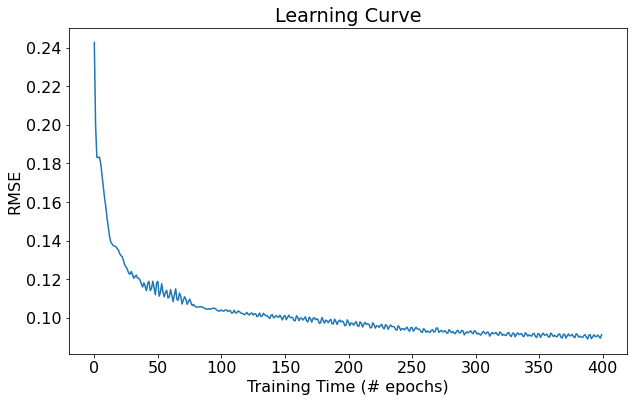

In [66]:
# Rescale losses based on stdev of the target outputs
rescaled_RMSE = np.sqrt(losses) / y_test.std()

# Plot the learning curve
plt.figure(figsize=(10,6))
plt.title('Learning Curve')
plt.xlabel('Training Time (# epochs)')
plt.ylabel(r'RMSE')
plt.plot(np.sqrt(losses))
plt.show()

## Visualization (Test Set)

In [67]:
# Length of the sequences used in the visualizations
T_viz = 100

# Target task for T=T_viz
y_all_viz = ERT_germany(dtype=dtype, seq_len=T_viz, 
    smooth=smooth, squash_to=squash_to,
    per_10k_population=per_10k_population,
    country_wide_total=country_wide_total,
    normalize=normalize, datadir=datadir
)[random_perm]

# Create the input sequences for the visualization
u_viz = compute_SW(y_all_viz, tau_minus)[:,:(T_viz-tau_plus)]

# Make a predictions
with torch.no_grad():
    rnn_out = network(u_viz, return_dynamics=True)
    hd = rnn_out[0]
    y_pred = rnn_out[-1]

# Order examples based on RNN performance
# TODO: implement

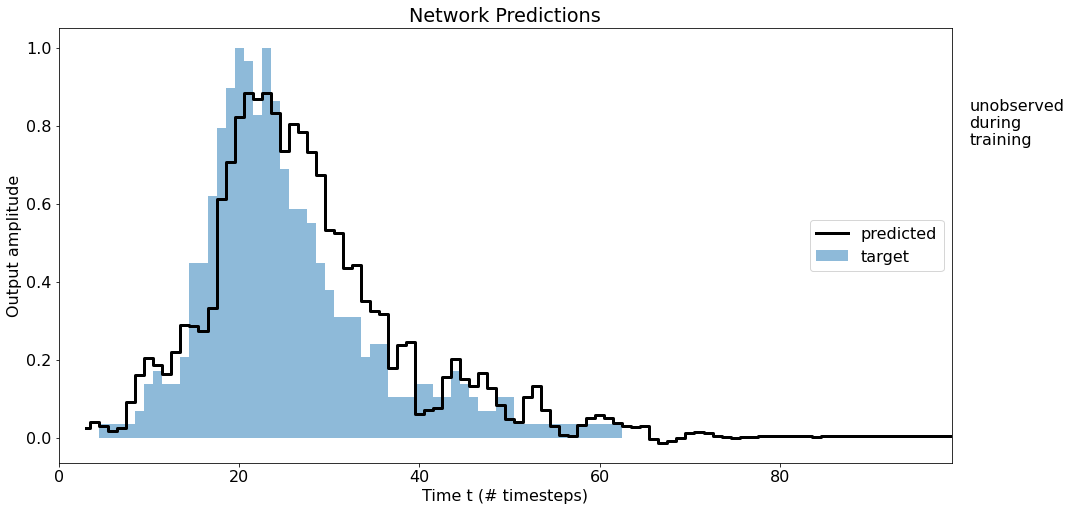

In [72]:
"""
Visualize predictions
"""
i_ex = np.random.randint(y.shape[0])

plt.figure(figsize=(16,8))
plt.title('Network Predictions')
plt.xlabel('Time t (# timesteps)')
plt.ylabel('Output amplitude')
plt.xlim(0,T_viz-1)
# Plot output target
plt.fill_between(
    np.arange(T_viz), y_all_viz[i_ex],
    step='mid', alpha=0.5,
    label='target'
)
# Plot network prediction
plt.plot(
    np.arange(tau_plus,T_viz), y_pred[i_ex],
    ds='steps-mid', c='k', linewidth=3,
    label='predicted'
)
plt.legend(loc='center right')
# Add a line to indicate data the network saw during training
plt.plot([T,T],[y_all_viz.min(), y_all_viz.max()], 'r', linewidth=3)
plt.text(T + 1, y_all_viz.max() * 0.75, 'unobserved\nduring\ntraining')
plt.show()

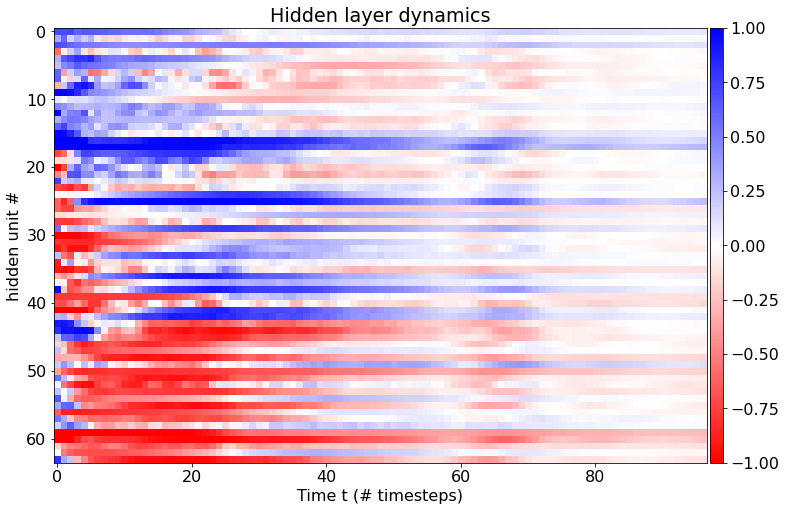

In [32]:
"""
Dynamics heatmap
"""

i_ex = -2

# Reshape and normalize
H = hd[i_ex].detach().numpy().reshape(-1, N_h)
H_centered = (H - np.mean(H, axis=0)) # / np.std(H, axis=0)

# Clustering
order = hierarchical_clustering(H_centered)

# Reorder dynamics heatmap
h_viz = np.zeros_like(H.T)
# Reorder columns of h
for j in range(N_h):
    h_viz[j] = H[:,order[j]]

plt.figure(figsize=(12,8))
plt.title('Hidden layer dynamics')
plt.xlabel('Time t (# timesteps)')
plt.ylabel('hidden unit #')
vmxx = np.max(np.abs(h_viz))
im = plt.imshow(h_viz, aspect='auto', interpolation='none', cmap='bwr_r',
    vmin=-1,vmax=1
)
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

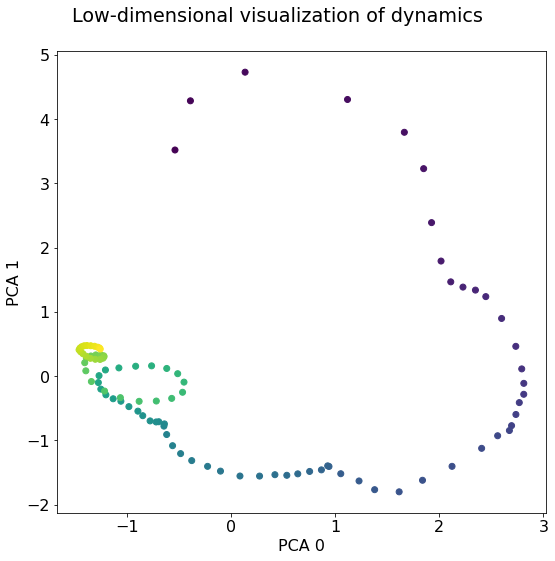

In [33]:
"""
PCA of Dynamics
"""

fig, ax = plt.subplots(1,1,figsize=(8,8))
fig.suptitle('Low-dimensional visualization of dynamics')

# Subplot 1: PCA
pca = PCA(n_components=5)
H_pca = pca.fit_transform(h_viz.T)

PCA_inds = [0,1]
ax.set_xlabel('PCA %d' % PCA_inds[0])
ax.set_ylabel('PCA %d' % PCA_inds[1])
ax.scatter(
    H_pca[:, PCA_inds[0]],
    H_pca[:, PCA_inds[1]],
    c=np.arange(H_pca.shape[0])/H_pca.shape[0]
)

plt.tight_layout()
plt.show()